In [1]:
# Character recognizer (Capitals) A to Z

In [22]:
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.cuda
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from PIL import Image

In [3]:
# data source : https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format?rvi=1
PATH = 'data/A_Z Handwritten Data.csv'
df = pd.read_csv(PATH).astype('float32')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: float32(785)
memory usage: 1.1 GB


In [5]:
alphabet_map = {i: chr(ord('A') + i) for i in range(26)}
alphabet_map

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z'}

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
X, y = df.iloc[:, 1:], df.iloc[:, 0]
X = X.to_numpy()
y = y.to_numpy()
X.shape

(372450, 784)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y)

# scale data
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)

X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [9]:
del df, X, y

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(335205, 784) (37245, 784) (335205,) (37245,)


In [11]:
type(y_train)

numpy.ndarray

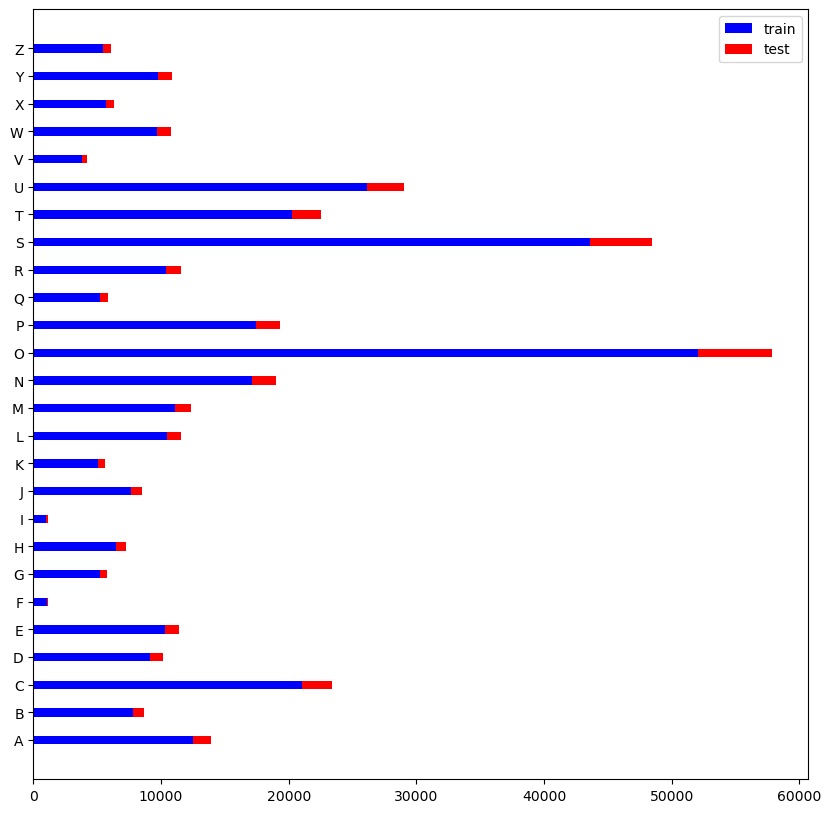

In [12]:
labels = list(alphabet_map.values())
np.count_nonzero(y_train == 9)
train_size, test_size = [], []
[(train_size.append((np.count_nonzero(y_train == i))), test_size.append((np.count_nonzero(y_test == i)))) for i in
 alphabet_map]

plt.figure(figsize=(10, 10))
plt.barh(y=labels, width=train_size, color="blue", height=0.3)
plt.barh(y=labels, width=test_size, left=train_size, color="red", height=0.3)
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
[(alphabet_map[i], np.count_nonzero(y_train == i), np.count_nonzero(y_test == i)) for i in alphabet_map]

[('A', 12482, 1387),
 ('B', 7801, 867),
 ('C', 21068, 2341),
 ('D', 9121, 1013),
 ('E', 10296, 1144),
 ('F', 1047, 116),
 ('G', 5186, 576),
 ('H', 6496, 722),
 ('I', 1008, 112),
 ('J', 7644, 849),
 ('K', 5043, 560),
 ('L', 10427, 1159),
 ('M', 11102, 1234),
 ('N', 17109, 1901),
 ('O', 52043, 5782),
 ('P', 17407, 1934),
 ('Q', 5231, 581),
 ('R', 10409, 1157),
 ('S', 43577, 4842),
 ('T', 20245, 2250),
 ('U', 26107, 2901),
 ('V', 3764, 418),
 ('W', 9706, 1078),
 ('X', 5645, 627),
 ('Y', 9773, 1086),
 ('Z', 5468, 608)]

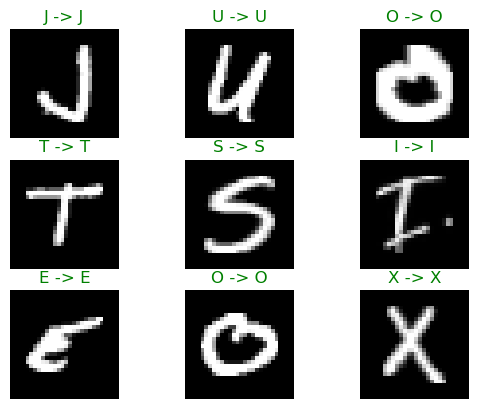

In [14]:
def show_img(X: np.ndarray, y: np.ndarray, pred: np.ndarray):
    X = X.reshape(-1, 28, 28)
    y = y.reshape(-1, 1)
    pred = pred.reshape(-1, 1)
    rows = columns = math.ceil(X.shape[0] ** 0.5)
    fig, axs = plt.subplots(rows, columns)
    for i in range(X.shape[0]):
        plt.subplot(rows, columns, i + 1)
        plt.axis('off')
        plt.imshow(X[i], cmap='grey')
        plt.title(f'{alphabet_map[y[i].item()]} -> {alphabet_map[pred[i].item()]}',
                  color=('red' if y[i].item() != pred[i].item() else 'green'))
    plt.show()


sample_index = 200000
sample_size = 9
show_img(X_train[sample_index:sample_index + sample_size], y_train[sample_index:sample_index + sample_size],
         y_train[sample_index:sample_index + sample_size])

In [15]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)

        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 26)
        self.dropout = nn.Dropout(0.2)

        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, input: torch.Tensor, train=False):
        input = input.view(-1, 1, 28, 28)
        # size = X * 28*28 * 1

        output = self.relu(self.pool(self.conv1(input)))
        # size = X * 12*12 * 6
        output = self.relu(self.pool(self.conv2(output)))
        # size = X * 4*4 * 16

        output = output.view(-1, 16 * 4 * 4)  # flattening
        # size = X * 256

        if train: output = self.dropout(output)
        output = self.l1(output)
        output = self.relu(output)

        if train: output = self.dropout(output)
        output = self.l2(output)
        output = self.relu(output)

        if train: output = self.dropout(output)
        output = self.l3(output)
        output = self.sig(output)
        return output

In [16]:
class CharacterDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, device=None):
        if not device:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.X = torch.Tensor(X).type(torch.float).to(device)
        self.y = torch.Tensor(y).type(torch.uint8).to(device)
        self.length = X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.length

In [17]:
train_dataset = CharacterDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=10000)

test_dataset = CharacterDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=10000)

del X_train, X_test, y_train, y_test

In [18]:
epochs = 50
learning_rate = 0.001
batch_size = 10000
model = Model(4 * 4 * 16, 120, 80).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
start_time = time.time()
for i in range(epochs):
    print(f'epoch = {i}/{epochs}')
    for j, (X_batch, y_batch) in enumerate(train_loader):
        pred = model(X_batch, train=True)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        correct = 0
        for j, (X_batch, y_batch) in enumerate(test_loader):
            pred_test = model(X_batch)
            pred_test = torch.argmax(pred_test, dim=1)
            correct += (pred_test == y_batch).sum().item()

        acc = 100 * (correct / len(test_dataset))
        print(f'loss = {loss.item():.3f}')
        print(f'accuracy = {acc:.3f}', end=2 * '\n')

end_time = time.time()
print(f'total {end_time - start_time:.3f} seconds on {device}.')

epoch = 0/50
loss = 3.045
accuracy = 15.524

epoch = 1/50
loss = 2.969
accuracy = 15.524

epoch = 2/50
loss = 2.787
accuracy = 22.035

epoch = 3/50
loss = 2.657
accuracy = 56.260

epoch = 4/50
loss = 2.575
accuracy = 67.982

epoch = 5/50
loss = 2.529
accuracy = 73.392

epoch = 6/50
loss = 2.487
accuracy = 79.495

epoch = 7/50
loss = 2.461
accuracy = 83.136

epoch = 8/50
loss = 2.448
accuracy = 86.017

epoch = 9/50
loss = 2.437
accuracy = 87.870

epoch = 10/50
loss = 2.433
accuracy = 88.922

epoch = 11/50
loss = 2.429
accuracy = 89.717

epoch = 12/50
loss = 2.422
accuracy = 90.243

epoch = 13/50
loss = 2.417
accuracy = 90.944

epoch = 14/50
loss = 2.413
accuracy = 91.381

epoch = 15/50
loss = 2.404
accuracy = 92.560

epoch = 16/50
loss = 2.399
accuracy = 93.156

epoch = 17/50
loss = 2.393
accuracy = 93.430

epoch = 18/50
loss = 2.390
accuracy = 93.690

epoch = 19/50
loss = 2.387
accuracy = 93.935

epoch = 20/50
loss = 2.386
accuracy = 94.093

epoch = 21/50
loss = 2.377
accuracy = 95.320

In [19]:
pred_test = torch.Tensor().to(device)
y_test = torch.Tensor().to(device)
for j, (X_batch, y_batch) in enumerate(test_loader):
    pred_batch = torch.argmax(model(X_batch), dim=1)
    pred_test = torch.cat((pred_test, pred_batch))
    y_test = torch.cat((y_test, y_batch))

pred_test = pred_test.to('cpu')
y_test = y_test.to('cpu')

conf_matrix = confusion_matrix(y_test, pred_test)
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

for i, acc in enumerate(accuracy_per_class):
    total = conf_matrix.sum(axis=1)[i]
    right = conf_matrix.diagonal()[i]
    wrong = total - right
    print(f'Accuracy "{alphabet_map[i]}": {acc * 100:5.2f}  {total:4.0f} : {right:4.0f}|{wrong:3.0f} ')

Accuracy "A": 99.35  1387 : 1378|  9 
Accuracy "B": 96.42   867 :  836| 31 
Accuracy "C": 98.33  2341 : 2302| 39 
Accuracy "D": 93.88  1013 :  951| 62 
Accuracy "E": 97.20  1144 : 1112| 32 
Accuracy "F":  0.00   116 :    0|116 
Accuracy "G": 94.10   576 :  542| 34 
Accuracy "H": 95.01   722 :  686| 36 
Accuracy "I":  0.00   112 :    0|112 
Accuracy "J": 95.52   849 :  811| 38 
Accuracy "K": 96.07   560 :  538| 22 
Accuracy "L": 97.15  1159 : 1126| 33 
Accuracy "M": 97.57  1234 : 1204| 30 
Accuracy "N": 98.05  1901 : 1864| 37 
Accuracy "O": 99.31  5782 : 5742| 40 
Accuracy "P": 97.88  1934 : 1893| 41 
Accuracy "Q": 95.35   581 :  554| 27 
Accuracy "R": 96.11  1157 : 1112| 45 
Accuracy "S": 99.01  4842 : 4794| 48 
Accuracy "T": 99.29  2250 : 2234| 16 
Accuracy "U": 98.69  2901 : 2863| 38 
Accuracy "V": 99.76   418 :  417|  1 
Accuracy "W": 96.85  1078 : 1044| 34 
Accuracy "X": 94.90   627 :  595| 32 
Accuracy "Y": 94.20  1086 : 1023| 63 
Accuracy "Z": 98.36   608 :  598| 10 


In [20]:
# # saving model's stats (parameters)
# FILE = 'character_recognizer_model.pth'
# torch.save(model.state_dict(), FILE)

In [36]:
def scaler(image: Image, scaler: MinMaxScaler):
    image = image.convert("L")
    transform = transforms.Compose([transforms.ToTensor()])

    image_tensor = transform(image)

    image_array = image_tensor.numpy().flatten().reshape(1, -1)

    scaled_image_array = scaler.transform(image_array)

    scaled_image_tensor = torch.tensor(scaled_image_array, dtype=torch.float32).reshape(28 * 28)

    return scaled_image_tensor

J  with probability : 0.703
V  with probability : 0.685
Y  with probability : 0.183
U  with probability : 0.139
T  with probability : 0.090


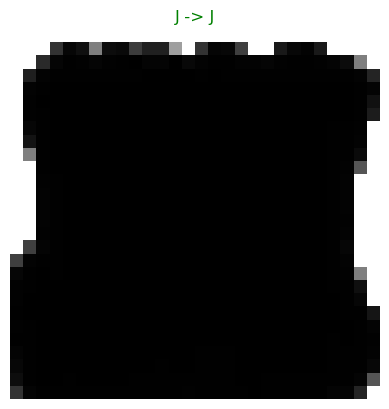

V  with probability : 0.786
J  with probability : 0.688
U  with probability : 0.178
Y  with probability : 0.177
N  with probability : 0.067


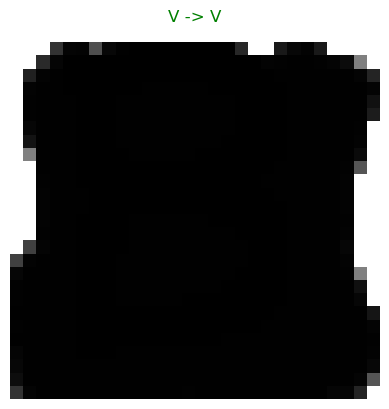

J  with probability : 0.693
V  with probability : 0.584
Y  with probability : 0.207
T  with probability : 0.178
S  with probability : 0.112


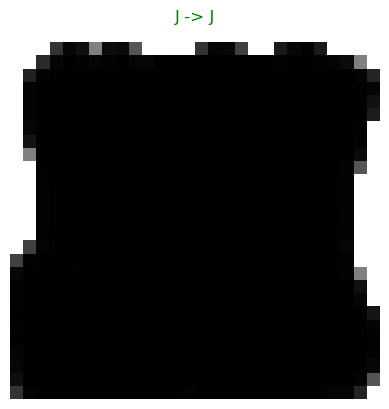

V  with probability : 0.776
J  with probability : 0.687
Y  with probability : 0.185
U  with probability : 0.178
N  with probability : 0.069


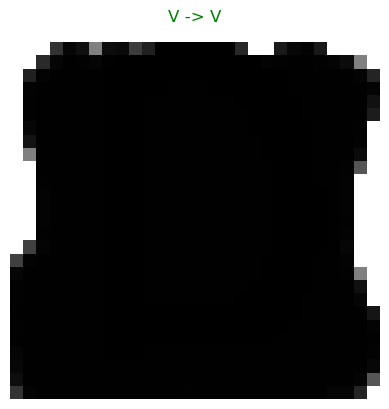

V  with probability : 0.828
J  with probability : 0.605
U  with probability : 0.283
N  with probability : 0.170
Y  with probability : 0.158


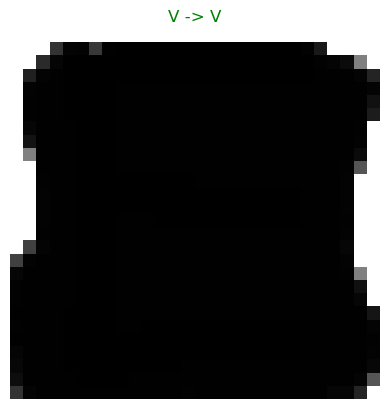

J  with probability : 0.691
V  with probability : 0.576
Y  with probability : 0.210
T  with probability : 0.189
S  with probability : 0.118


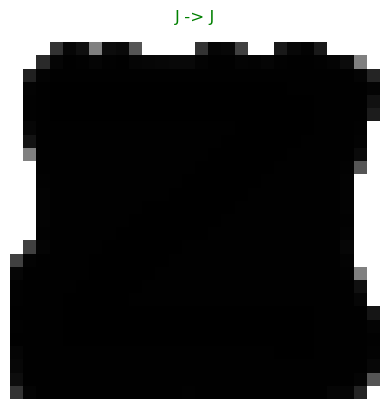

J  with probability : 0.692
V  with probability : 0.567
Y  with probability : 0.208
T  with probability : 0.191
S  with probability : 0.122


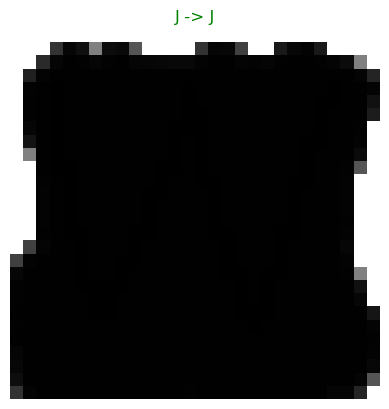

J  with probability : 0.693
V  with probability : 0.563
Y  with probability : 0.204
T  with probability : 0.199
S  with probability : 0.125


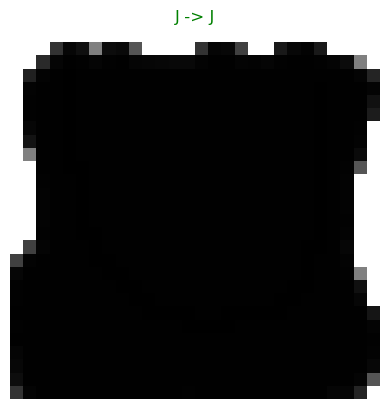

J  with probability : 0.694
V  with probability : 0.566
Y  with probability : 0.208
T  with probability : 0.191
S  with probability : 0.122


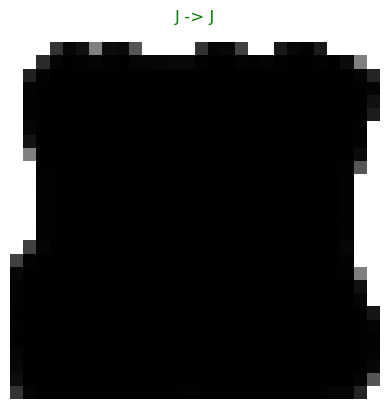

J  with probability : 0.691
V  with probability : 0.577
Y  with probability : 0.206
T  with probability : 0.187
S  with probability : 0.117


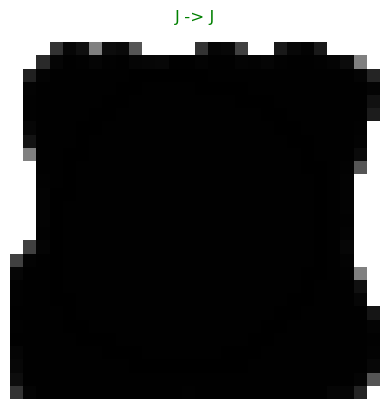

V  with probability : 0.757
J  with probability : 0.699
U  with probability : 0.225
Y  with probability : 0.176
N  with probability : 0.107


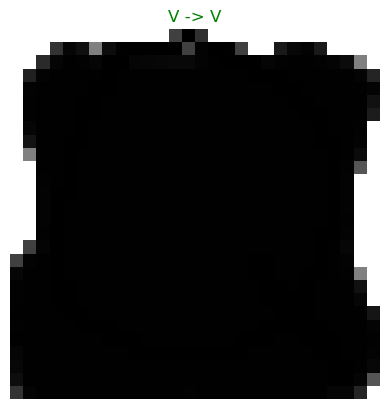

J  with probability : 0.692
V  with probability : 0.590
Y  with probability : 0.209
T  with probability : 0.171
U  with probability : 0.115


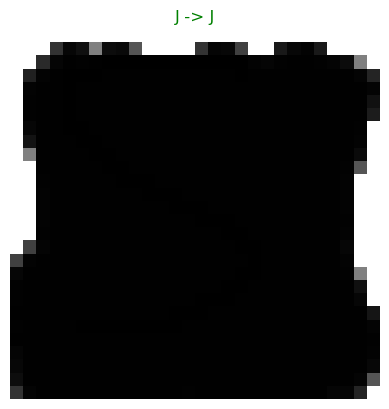

In [38]:
for i in range(0, 12):
    image_path = f'manual_test/{i}.png'
    image = Image.open(image_path)
    x = 1 - x
    x = scaler(image=image, scaler=min_max_scaler)
    x = x.to(device)
    pred = model(x)
    top_values, top_indices = torch.topk(pred, k=5, sorted=True)
    for i, (value, index) in enumerate(zip(top_values[0], top_indices[0]), 1):
        print(f"{alphabet_map[index.item()]}  with probability : {value:2.3f}")

    pred = pred.argmax().item()

    x = x.to('cpu')
    x = x.numpy()
    show_img(x, np.array(pred), np.array(pred))